In [118]:
%matplotlib inline
from IPython import display
import os
import io
import itertools
import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import importlib

import rtmtools.lblrtm.aerutils as aerutils
import rtmtools.lblrtm.aeranalyse as aeranalyse
import rtmtools.lblrtm.visualisation as viz

import rtmtools.clirad.sw.wrangle as cliradwrangle
import rtmtools.clirad.sw.analyse as cliradanalyse
import rtmtools.clirad.sw.info

import rtmtools.rrtmg.sw.wrangle as rrtmgwrangle
import rtmtools.rrtmg.sw.analyse as rrtmganalyse



importlib.reload(aerutils)
importlib.reload(aeranalyse)
importlib.reload(viz)

importlib.reload(cliradwrangle)
importlib.reload(cliradanalyse)
importlib.reload(rtmtools.clirad.sw.info)

importlib.reload(rrtmgwrangle)
importlib.reload(rrtmganalyse)


<module 'rtmtools.rrtmg.sw.analyse' from '/nuwa_cluster/home/jackyu/radiation/rtmtools/rtmtools/rrtmg/sw/analyse.py'>

In [2]:
name_molecule = r'$H_{2}O$'

In [124]:
# Load CRD results

# CRD H2008
pathout_crd = '/nuwa_cluster/home/jackyu/radiation/crd/SW/examples/mls75_H2O/OUTPUT_CRD.dat'
pnl_crd = aerutils.OUTPUT_RADSUM_to_pandasPanel(readfrom = pathout_crd, signed_fluxes = True)


In [ ]:
# CRD H2012
pathout_crd = '../crd/SW/examples/mls75_H2O_solzen_60_H2012/OUTPUT_CRD.dat'
pnl_crd_H2012 = aerutils.OUTPUT_RADSUM_to_pandasPanel(readfrom = pathout_crd, signed_fluxes = True)

In [7]:
# Load CLIRAD results
pathout_clirad = '/nuwa_cluster/home/jackyu/radiation/clirad/SW/examples/mls75_H2O/OUTPUT_CLIRAD.dat'
pnl_clirad = cliradwrangle.OUTPUT_CLIRAD_to_PandasPanel(readfrom = pathout_clirad, signed_fluxes = True)

In [4]:
# Load AER RRTMG's results
pathout_rrtmg = '/nuwa_cluster/home/jackyu/radiation/rrtmg/SW/examples/mls_71lvls_H2O/OUTPUT_RRTM'
pnl_rrtmg = rrtmgwrangle.OUTPUT_RRTM_to_pandasPanel(readfrom = pathout_rrtmg, signed_fluxes = True)

# 'Total' heating rates

In [127]:
def plot_total_heating_rates(infos_wavenumber = None, infos_spectralband = None):
    global molecule_name, xlim_linear
    atm_levels = [70, 30, 0]
    
    names_wavenumber, colours_wavenumber, linestyles_wavenumber, pnls_wavenumber = \
    map(list, zip(*infos_wavenumber))
    
    dfs_wavenumber = [aeranalyse.sum_OUTPUT_RADSUM_over_wbands(pnl, V1 = 1000, V2 = 25000) \
                      for pnl in pnls_wavenumber]
    
    names_spectralband, colours_spectralband, linestyles_spectralband, pnls_spectralband = \
    map(list, zip(*infos_spectralband))
    
    dfs_spectralband = [cliradanalyse.sum_OUTPUT_CLIRAD_over_wbands(pnl, wbands = range(1, 11))\
                       for pnl in pnls_spectralband]

    dfs = dfs_wavenumber + dfs_spectralband
    names = names_wavenumber + names_spectralband
    colours = colours_wavenumber + colours_spectralband
    linestyles = linestyles_wavenumber + linestyles_spectralband    
    
    dfs_atm_levels = [df.loc[atm_levels, :] for df in dfs]
    
    viz.tabulate_difference(dfs = dfs_atm_levels, 
                            names = names,
                            title = 'Total heating rate. {}'.format(name_molecule))    
    
    max_cr = max([df['heating_rate'].max() for df in dfs])
    
    viz.plot_pres_vs_hrcr(dfs = dfs_wavenumber + dfs_spectralband,
                          names = names_wavenumber + names_spectralband,
                          linestyles = linestyles_wavenumber + linestyles_spectralband, 
                          colours = colours_wavenumber + colours_spectralband,
                          title = 'Total heating rate. {}'.format(name_molecule),
                          cooling_rate = False,
                          xlim_linear = None,
                          xlim_log = None)
    
    display.display(plt.gcf()); plt.close()
    


Total heating rate. $H_{2}O$

CRD
       pressure  flux_up   flux_down    net_flux  heating_rate
70     0.002417        0  629.330637  629.330637      0.461031
30   299.800000        0  620.060750  620.060750      0.989600
0   1013.000000        0  515.385483  515.385483      1.222241

CRD H2012
       pressure  flux_up   flux_down    net_flux  heating_rate
70     0.002417        0  629.330652  629.330652      0.461621
30   299.800000        0  619.993131  619.993131      0.997016
0   1013.000000        0  514.838220  514.838220      1.218964

RRTMG
      pressure   flux_up  flux_difdown  flux_dirdown   flux_down    net_flux  \
70     0.00242 -0.000201             0      592.7477  594.246265  594.246065   
30   299.70000 -0.000099             0      582.0274  583.539671  583.539572   
0   1013.00000  0.000000             0      477.3102  478.006774  478.006774   

    heating_rate  
70       0.00000  
30       1.01312  
0        1.22063  

CLIRAD
       pressure   flux_up   flux_down 

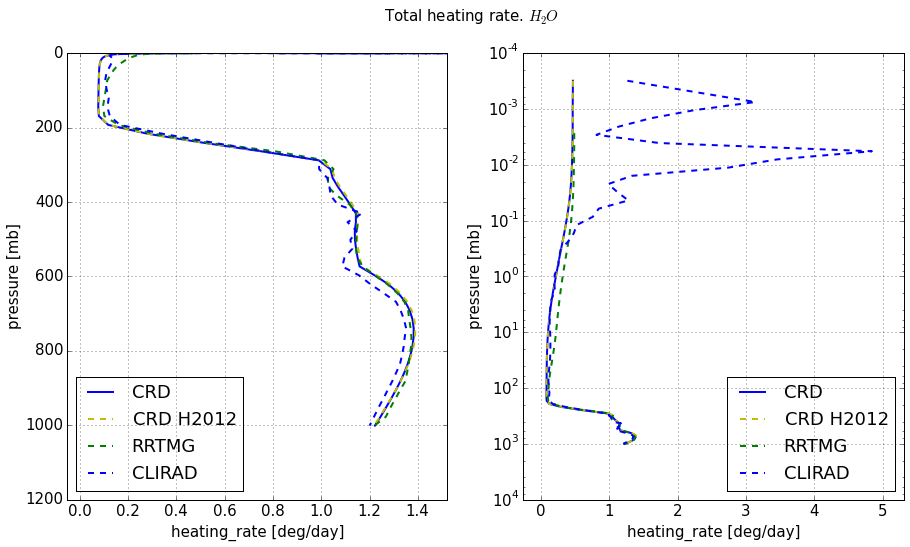

In [135]:
plot_total_heating_rates(infos_wavenumber = [('CRD', 'b', '-', pnl_crd),
                                             ('CRD H2012', 'y', '--', pnl_crd_H2012),
                                            ('RRTMG', 'g', '--', pnl_rrtmg)],
                        infos_spectralband = [('CLIRAD', 'b', '--', pnl_clirad)])

# In selected spectral bands

In [133]:
# By arbitrary bands

def define_spectral_bands():
    return [(1000, 4400),
           (4400, 8200),
           (8200, 14280),
           (14280, 25000),
           (1000, 25000)]


def fluxtableNhrplot_by_bands(bands, *infos_lbl):
    global name_molecule, xlim_linear
    
    atm_levels = [70, 30, 0]
    
    names, colours, linestyles, pnls_lbl = map(list, zip(*infos_lbl))
          
    pnls = [aeranalyse.lines2bands(pnl_lbl, wbands = bands)\
            for pnl_lbl in pnls_lbl]
    
    
    for item in bands:
        print('---------------------------------------------------------------------------')
        print() 
        dfs = [pnl[item].loc[atm_levels, :] for pnl in pnls]
        
        viz.tabulate_difference(dfs = dfs, 
                                names = names,
                                title = 'Wavenumber band: {} ~ {} cm-1'.format(*item))      
        
        dfs = [pnl[item] for pnl in pnls]
        
        max_cr = max([df['heating_rate'].max() for df in dfs])
        
        viz.plot_pres_vs_hrcr(dfs = dfs,
                              names = names,
                              linestyles = linestyles, 
                              colours = colours,
                              title = 'Heating rate {} {} ~ {} cm-1'.format(name_molecule, *item),
                              cooling_rate = False,
                              xlim_linear = None,
                              xlim_log = None)
    
        display.display(plt.gcf()); plt.close()

Flux tables and heating rates in various spectral bands


---------------------------------------------------------------------------


Wavenumber band: 1000 ~ 4400 cm-1

CRD
       pressure  flux_up  flux_down   net_flux  heating_rate
70     0.002417        0  29.352153  29.352153      0.351053
30   299.800000        0  25.503405  25.503405      0.355012
0   1013.000000        0  10.547747  10.547747      0.100244

CRD H2012
       pressure  flux_up  flux_down   net_flux  heating_rate
70     0.002417        0  29.352152  29.352152      0.352367
30   299.800000        0  25.499421  25.499421      0.355324
0   1013.000000        0  10.532794  10.532794      0.100384

CRD - CRD H2012
    pressure  flux_up  flux_down  net_flux  heating_rate
70         0        0   0.000002  0.000002     -0.001315
30         0        0   0.003984  0.003984     -0.000312
0          0        0   0.014953  0.014953     -0.000139



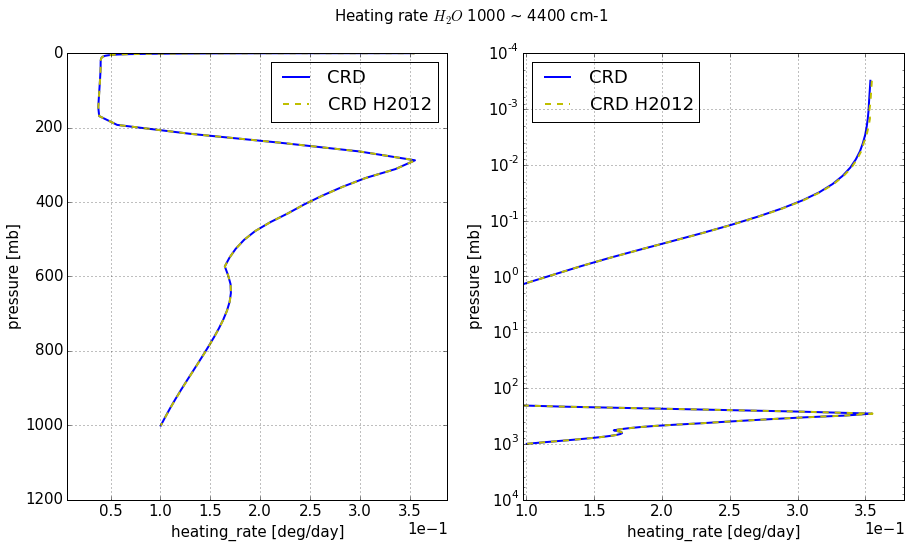

---------------------------------------------------------------------------


Wavenumber band: 4400 ~ 8200 cm-1

CRD
       pressure  flux_up   flux_down    net_flux  heating_rate
70     0.002417        0  113.874482  113.874482      0.104813
30   299.800000        0  109.312006  109.312006      0.514142
0   1013.000000        0   65.972910   65.972910      0.315031

CRD H2012
       pressure  flux_up   flux_down    net_flux  heating_rate
70     0.002417        0  113.874481  113.874481      0.103635
30   299.800000        0  109.308523  109.308523      0.514424
0   1013.000000        0   65.936687   65.936687      0.317339

CRD - CRD H2012
    pressure  flux_up     flux_down      net_flux  heating_rate
70         0        0  4.390007e-07  4.390007e-07      0.001178
30         0        0  3.483420e-03  3.483420e-03     -0.000282
0          0        0  3.622293e-02  3.622293e-02     -0.002308



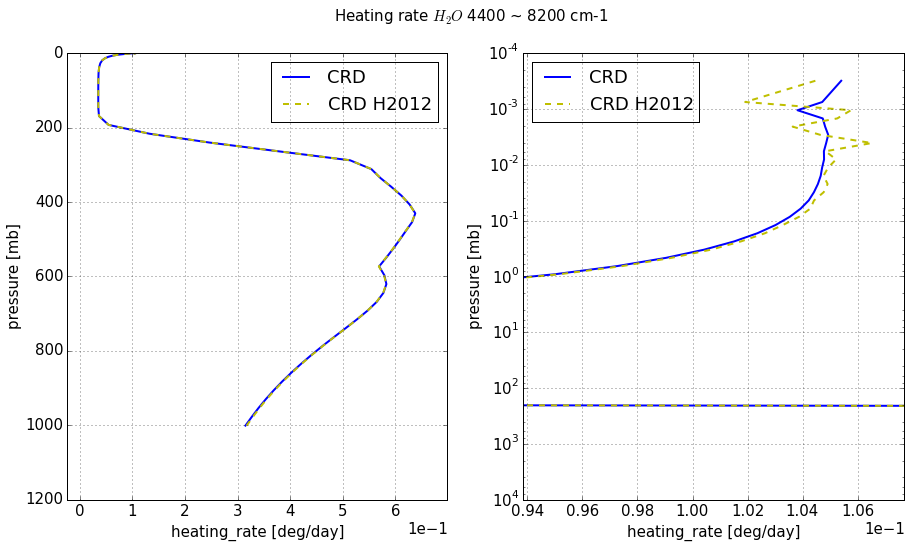

---------------------------------------------------------------------------


Wavenumber band: 8200 ~ 14280 cm-1

CRD
       pressure  flux_up   flux_down    net_flux  heating_rate
70     0.002417        0  220.865503  220.865503      0.005160
30   299.800000        0  220.015104  220.015104      0.119130
0   1013.000000        0  176.023173  176.023173      0.735974

CRD H2012
       pressure  flux_up   flux_down    net_flux  heating_rate
70     0.002417        0  220.865516  220.865516      0.005619
30   299.800000        0  219.955098  219.955098      0.125926
0   1013.000000        0  175.592757  175.592757      0.728109

CRD - CRD H2012
    pressure  flux_up  flux_down  net_flux  heating_rate
70         0        0  -0.000013 -0.000013     -0.000459
30         0        0   0.060006  0.060006     -0.006796
0          0        0   0.430416  0.430416      0.007866



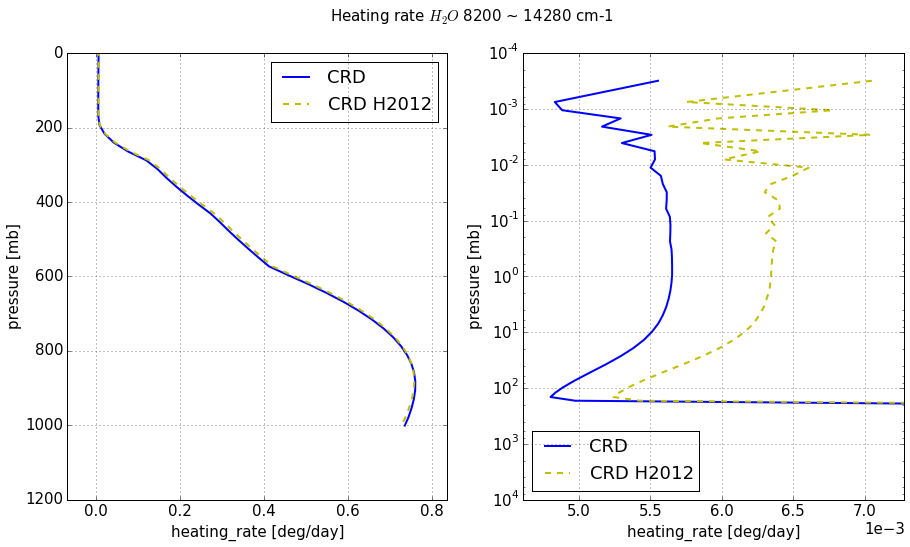

---------------------------------------------------------------------------


Wavenumber band: 14280 ~ 25000 cm-1

CRD
       pressure  flux_up   flux_down    net_flux  heating_rate
70     0.002417        0  265.238499  265.238499      0.000006
30   299.800000        0  265.230235  265.230235      0.001316
0   1013.000000        0  262.841654  262.841654      0.070991

CRD H2012
       pressure  flux_up   flux_down    net_flux  heating_rate
70     0.002417        0  265.238503  265.238503      0.000000
30   299.800000        0  265.230089  265.230089      0.001341
0   1013.000000        0  262.775982  262.775982      0.073132

CRD - CRD H2012
    pressure  flux_up  flux_down  net_flux  heating_rate
70         0        0  -0.000004 -0.000004      0.000006
30         0        0   0.000146  0.000146     -0.000025
0          0        0   0.065672  0.065672     -0.002141



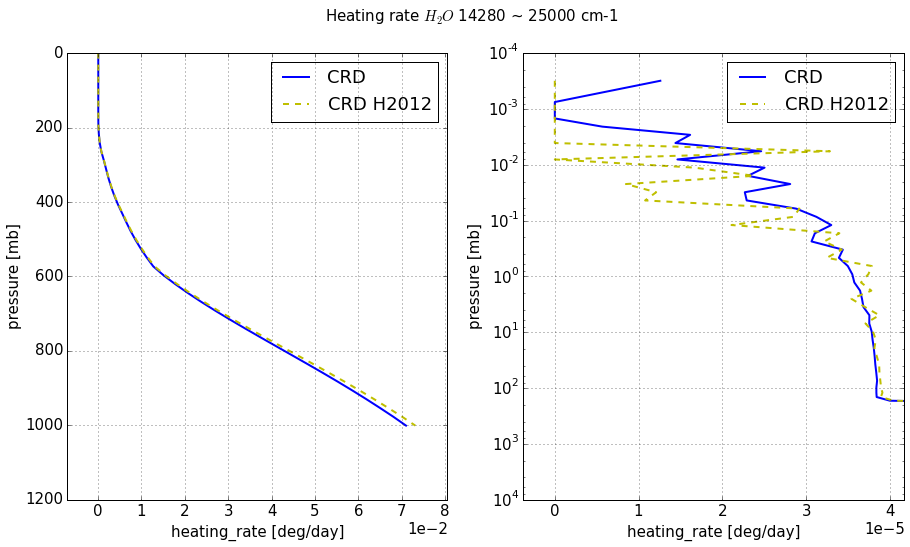

---------------------------------------------------------------------------


Wavenumber band: 1000 ~ 25000 cm-1

CRD
       pressure  flux_up   flux_down    net_flux  heating_rate
70     0.002417        0  629.330637  629.330637      0.461031
30   299.800000        0  620.060750  620.060750      0.989600
0   1013.000000        0  515.385483  515.385483      1.222241

CRD H2012
       pressure  flux_up   flux_down    net_flux  heating_rate
70     0.002417        0  629.330652  629.330652      0.461621
30   299.800000        0  619.993131  619.993131      0.997016
0   1013.000000        0  514.838220  514.838220      1.218964

CRD - CRD H2012
    pressure  flux_up  flux_down  net_flux  heating_rate
70         0        0  -0.000015 -0.000015     -0.000590
30         0        0   0.067619  0.067619     -0.007416
0          0        0   0.547264  0.547264      0.003277



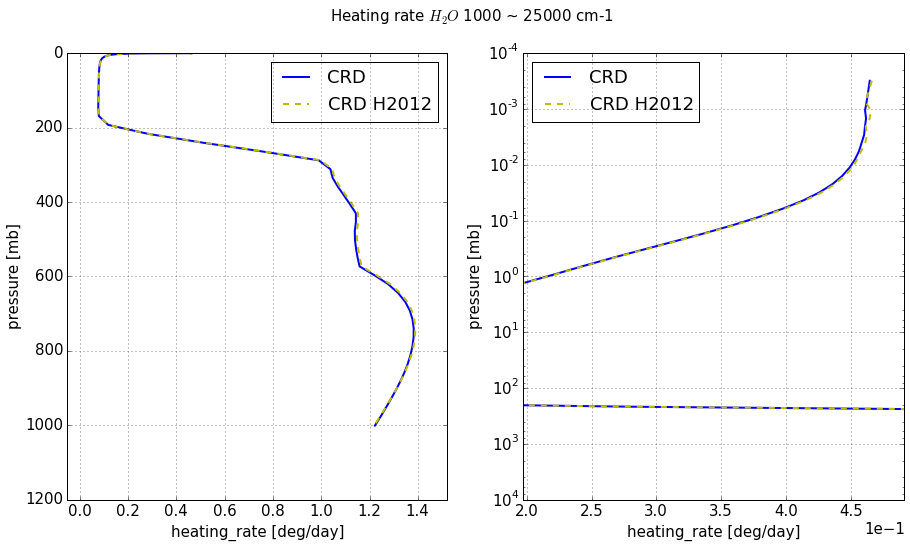

In [136]:
print('Flux tables and heating rates in various spectral bands')
print()
print()

fluxtableNhrplot_by_bands(define_spectral_bands(), \
                         ('CRD', 'b', '-', pnl_crd),
                         ('CRD H2012', 'y', '--', pnl_crd_H2012))

# In RRMTG's wavenumber bands

In [116]:

def fluxtableNhrplot_by_rrtmg_bands(pnl_rrtmg, *infos_lbl):
    global name_molecule, xlim_linear
    
    atm_levels = [70, 30, 0]
    
    names, colours, linestyles, pnls_lbl = map(list, zip(*infos_lbl))
        
    
    
    pnls = [aeranalyse.lines2bands(pnl_lbl, wbands = pnl_rrtmg.items.values)\
            for pnl_lbl in pnls_lbl]
    
    names.append('RRTMG')
    colours.append('g')
    linestyles.append('--')
    
    aeranalyse.normalise_by_TOA_flux_down(pnl_rrtmg, 
                                          normalise_to = pnls[0])
    
    pnls.append(pnl_rrtmg)
    
    
    for item in pnl_rrtmg.items:
        print('---------------------------------------------------------------------------')
        print() 
        dfs = [pnl[item].loc[atm_levels, :] for pnl in pnls]
        
        viz.tabulate_difference(dfs = dfs, 
                                names = names,
                                title = 'RRTMG Wavenumber band: {} ~ {} cm-1'.format(*item))      
        
        dfs = [pnl[item] for pnl in pnls]
        
        max_cr = max([df['heating_rate'].max() for df in dfs])
        
        viz.plot_pres_vs_hrcr(dfs = dfs,
                              names = names,
                              linestyles = linestyles, 
                              colours = colours,
                              title = 'Heating rate {} {} ~ {} cm-1'.format(name_molecule, *item),
                              cooling_rate = False,
                             xlim_linear = None,
                             xlim_log = None)
    
        display.display(plt.gcf()); plt.close()

Flux tables and heating rates in RRTMG spectral bands


---------------------------------------------------------------------------


RRTMG Wavenumber band: 820.0 ~ 2600.0 cm-1

CRD
       pressure  flux_up  flux_down  net_flux  heating_rate
70     0.002417        0   6.190729  6.190729      0.075417
30   299.800000        0   5.527701  5.527701      0.059484
0   1013.000000        0   3.251457  3.251457      0.017369

CRD H2012
       pressure  flux_up  flux_down  net_flux  heating_rate
70     0.002417        0   6.190728  6.190728      0.076435
30   299.800000        0   5.521796  5.521796      0.059959
0   1013.000000        0   3.239135  3.239135      0.017324

RRTMG
      pressure  flux_up  flux_difdown  flux_dirdown  flux_down  net_flux  \
70     0.00242       -0             0        6.4447   6.190729  6.190729   
30   299.70000       -0             0        4.7174   4.531498  4.531498   
0   1013.00000       -0             0        1.8674   1.793810  1.793810   

    heating_rat

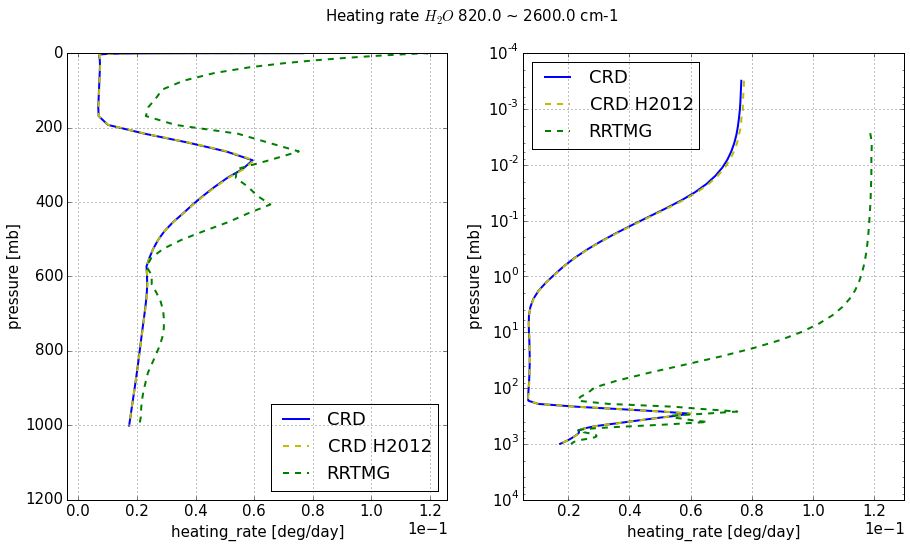

---------------------------------------------------------------------------


RRTMG Wavenumber band: 2600.0 ~ 3250.0 cm-1

CRD
       pressure  flux_up  flux_down  net_flux  heating_rate
70     0.002417        0   6.046376  6.046376      0.001314
30   299.800000        0   5.911883  5.911883      0.016950
0   1013.000000        0   2.861515  2.861515      0.034454

CRD H2012
       pressure  flux_up  flux_down  net_flux  heating_rate
70     0.002417        0   6.046375  6.046375      0.001371
30   299.800000        0   5.912104  5.912104      0.016923
0   1013.000000        0   2.861435  2.861435      0.034531

RRTMG
      pressure  flux_up  flux_difdown  flux_dirdown  flux_down  net_flux  \
70     0.00242       -0             0        6.0548   6.046376  6.046376   
30   299.70000       -0             0        5.9225   5.914260  5.914260   
0   1013.00000       -0             0        2.8829   2.878889  2.878889   

    heating_rate  
70       0.00000  
30       0.01725  
0        0.03

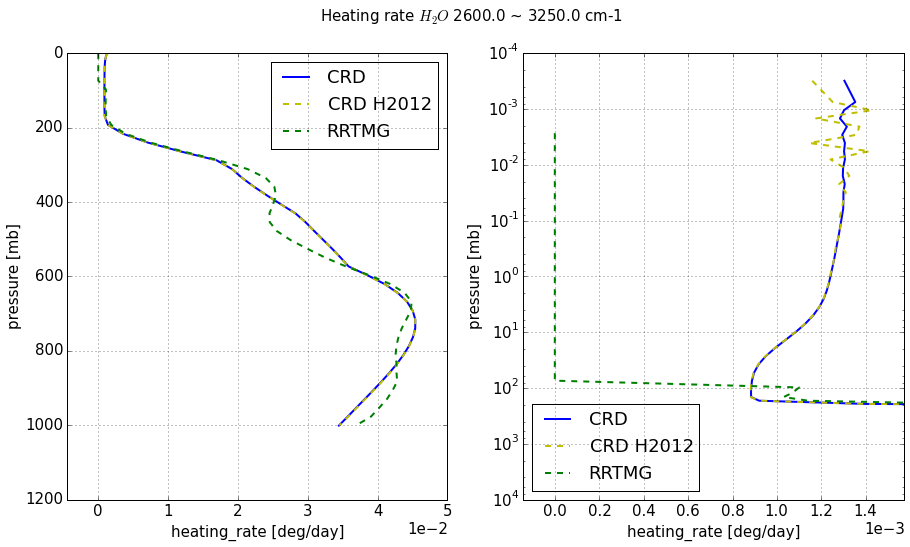

---------------------------------------------------------------------------


RRTMG Wavenumber band: 3250.0 ~ 4000.0 cm-1

CRD
       pressure  flux_up  flux_down   net_flux  heating_rate
70     0.002417        0  10.192548  10.192548      0.273868
30   299.800000        0   7.202094   7.202094      0.270346
0   1013.000000        0   0.153980   0.153980      0.011476

CRD H2012
       pressure  flux_up  flux_down   net_flux  heating_rate
70     0.002417        0  10.192548  10.192548      0.274245
30   299.800000        0   7.203785   7.203785      0.270210
0   1013.000000        0   0.154372   0.154372      0.011493

RRTMG
      pressure  flux_up  flux_difdown  flux_dirdown  flux_down   net_flux  \
70     0.00242       -0             0       10.1825  10.192548  10.192548   
30   299.70000       -0             0        7.1431   7.150149   7.150149   
0   1013.00000       -0             0        0.0520   0.052051   0.052051   

    heating_rate  
70       0.00000  
30       0.26814  
0

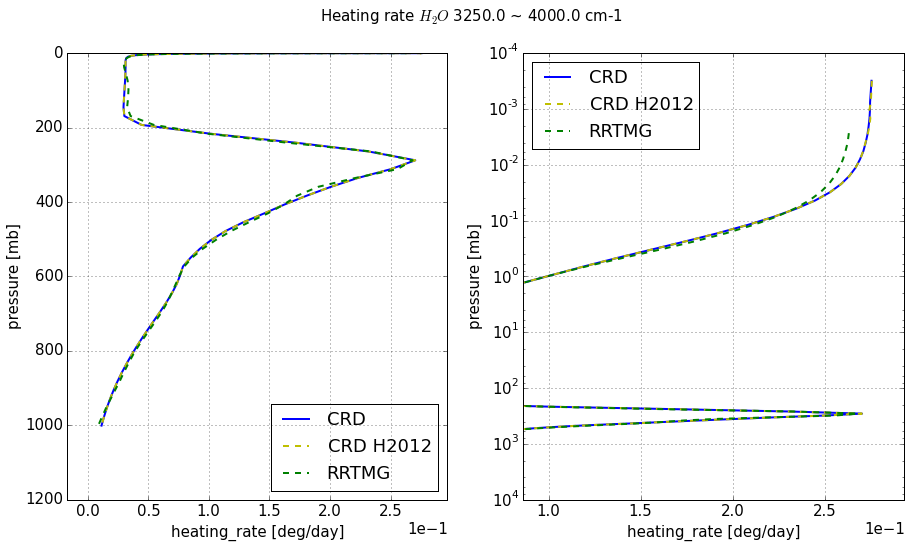

---------------------------------------------------------------------------


RRTMG Wavenumber band: 4000.0 ~ 4650.0 cm-1

CRD
       pressure  flux_up  flux_down   net_flux  heating_rate
70     0.002417        0  11.837002  11.837002      0.000453
30   299.800000        0  11.774872  11.774872      0.008451
0   1013.000000        0   8.867145   8.867145      0.045377

CRD H2012
       pressure  flux_up  flux_down   net_flux  heating_rate
70     0.002417        0  11.837001  11.837001      0.000317
30   299.800000        0  11.774925  11.774925      0.008443
0   1013.000000        0   8.870176   8.870176      0.045389

RRTMG
      pressure  flux_up  flux_difdown  flux_dirdown  flux_down   net_flux  \
70     0.00242       -0             0       11.8649  11.837002  11.837002   
30   299.70000       -0             0       11.7935  11.765770  11.765770   
0   1013.00000       -0             0        8.6833   8.662883   8.662883   

    heating_rate  
70       0.00000  
30       0.00925  
0

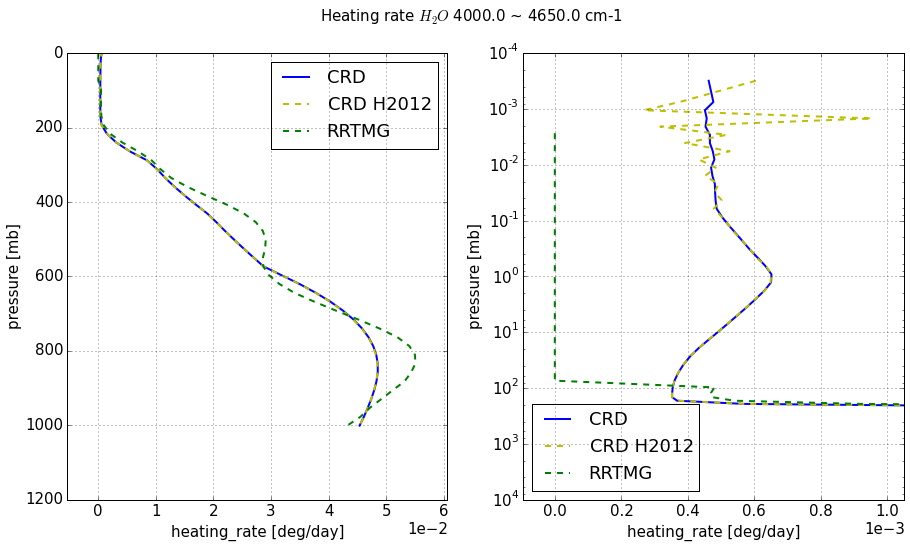

---------------------------------------------------------------------------


RRTMG Wavenumber band: 4650.0 ~ 5150.0 cm-1

CRD
       pressure  flux_up  flux_down   net_flux  heating_rate
70     0.002417        0  11.175502  11.175502      0.000266
30   299.800000        0  11.121692  11.121692      0.008158
0   1013.000000        0   7.732939   7.732939      0.050570

CRD H2012
       pressure  flux_up  flux_down   net_flux  heating_rate
70     0.002417        0  11.175499  11.175499      0.000317
30   299.800000        0  11.122375  11.122375      0.008053
0   1013.000000        0   7.775277   7.775277      0.050066

RRTMG
      pressure  flux_up  flux_difdown  flux_dirdown  flux_down   net_flux  \
70     0.00242       -0             0       11.2138  11.175502  11.175502   
30   299.70000       -0             0       11.1614  11.123281  11.123281   
0   1013.00000       -0             0        7.8399   7.813124   7.813124   

    heating_rate  
70       0.00000  
30       0.00813  
0

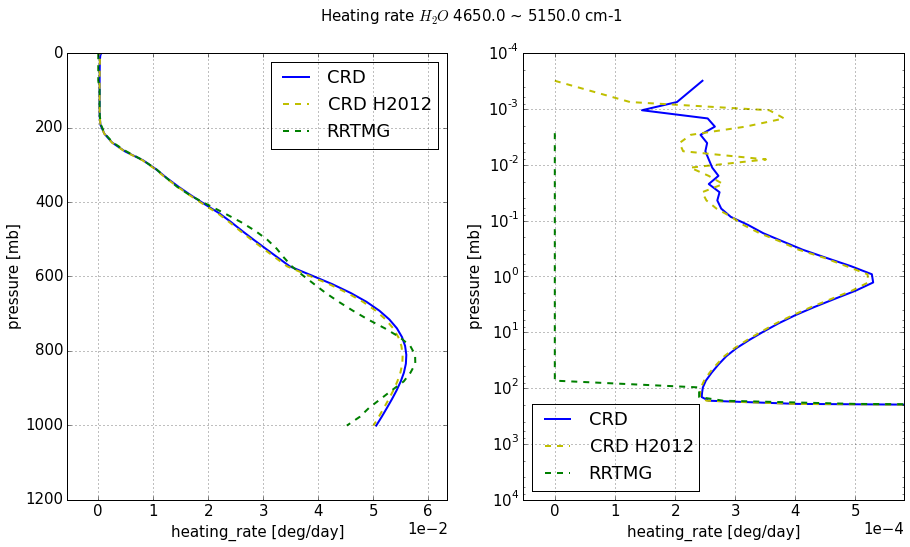

---------------------------------------------------------------------------


RRTMG Wavenumber band: 5150.0 ~ 6150.0 cm-1

CRD
       pressure  flux_up  flux_down   net_flux  heating_rate
70     0.002417        0  28.035864  28.035864      0.051710
30   299.800000        0  26.271317  26.271317      0.190879
0   1013.000000        0  14.381275  14.381275      0.060881

CRD H2012
       pressure  flux_up  flux_down   net_flux  heating_rate
70     0.002417        0  28.035864  28.035864      0.052293
30   299.800000        0  26.267817  26.267817      0.191215
0   1013.000000        0  14.374373  14.374373      0.061013

RRTMG
      pressure  flux_up  flux_difdown  flux_dirdown  flux_down   net_flux  \
70     0.00242       -0             0       27.8133  28.035864  28.035864   
30   299.70000       -0             0       25.9028  26.110076  26.110076   
0   1013.00000       -0             0       13.8181  13.928673  13.928673   

    heating_rate  
70       0.00000  
30       0.19698  
0

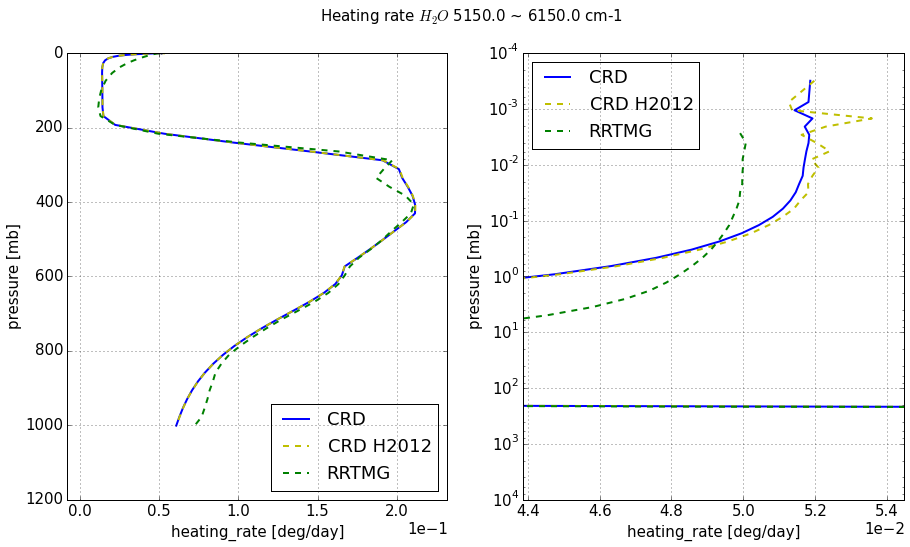

---------------------------------------------------------------------------


RRTMG Wavenumber band: 6150.0 ~ 7700.0 cm-1

CRD
       pressure  flux_up  flux_down   net_flux  heating_rate
70     0.002417        0  51.855615  51.855615      0.052831
30   299.800000        0  49.114584  49.114584      0.314601
0   1013.000000        0  22.024083  22.024083      0.176725

CRD H2012
       pressure  flux_up  flux_down   net_flux  heating_rate
70     0.002417        0  51.855615  51.855615      0.051024
30   299.800000        0  49.113963  49.113963      0.314643
0   1013.000000        0  21.995314  21.995314      0.177889

RRTMG
      pressure  flux_up  flux_difdown  flux_dirdown  flux_down   net_flux  \
70     0.00242       -0             0       51.4658  51.855615  51.855615   
30   299.70000       -0             0       48.5907  48.958738  48.958738   
0   1013.00000       -0             0       21.8532  22.018722  22.018722   

    heating_rate  
70       0.00000  
30       0.32089  
0

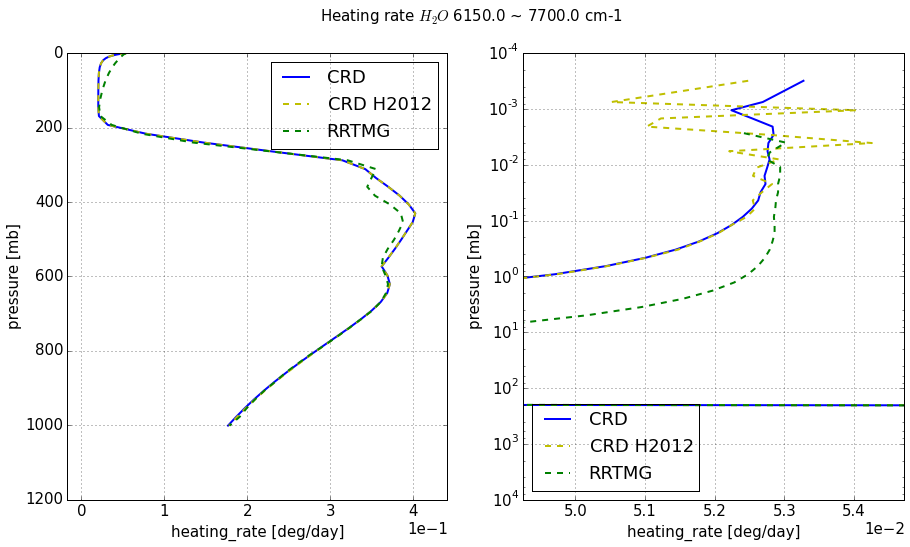

---------------------------------------------------------------------------


RRTMG Wavenumber band: 7700.0 ~ 8050.0 cm-1

CRD
       pressure  flux_up  flux_down   net_flux  heating_rate
70     0.002417        0  12.480126  12.480126      0.000006
30   299.800000        0  12.479372  12.479372      0.000127
0   1013.000000        0  12.131531  12.131531      0.010220

CRD H2012
       pressure  flux_up  flux_down   net_flux  heating_rate
70     0.002417        0  12.480128  12.480128      0.000000
30   299.800000        0  12.479366  12.479366      0.000129
0   1013.000000        0  12.111669  12.111669      0.010985

RRTMG
      pressure  flux_up  flux_difdown  flux_dirdown  flux_down   net_flux  \
70     0.00242       -0             0       12.1468  12.480126  12.480126   
30   299.70000       -0             0       12.1462  12.479509  12.479509   
0   1013.00000       -0             0       11.7689  12.091855  12.091855   

    heating_rate  
70       0.00000  
30       0.00011  
0

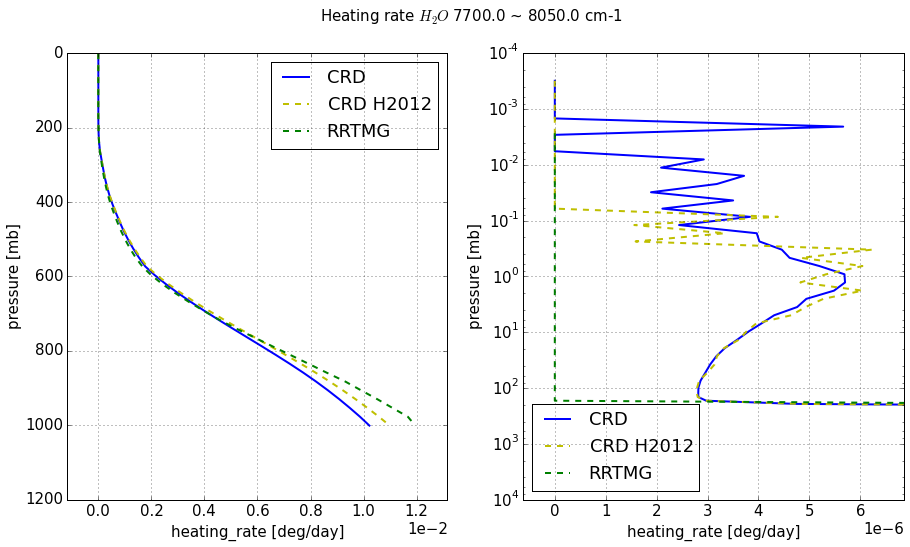

---------------------------------------------------------------------------


RRTMG Wavenumber band: 8050.0 ~ 12850.0 cm-1

CRD
       pressure  flux_up   flux_down    net_flux  heating_rate
70     0.002417        0  175.812128  175.812128      0.005121
30   299.800000        0  174.987290  174.987290      0.115096
0   1013.000000        0  134.939325  134.939325      0.644180

CRD H2012
       pressure  flux_up   flux_down    net_flux  heating_rate
70     0.002417        0  175.812141  175.812141      0.005528
30   299.800000        0  174.926855  174.926855      0.121961
0   1013.000000        0  134.369180  134.369180      0.640213

RRTMG
      pressure   flux_up  flux_difdown  flux_dirdown   flux_down    net_flux  \
70     0.00242 -0.000102             0      172.8713  175.812128  175.812026   
30   299.70000 -0.000000             0      171.9919  174.917768  174.917768   
0   1013.00000 -0.000000             0      132.7270  134.984907  134.984907   

    heating_rate  
70       0

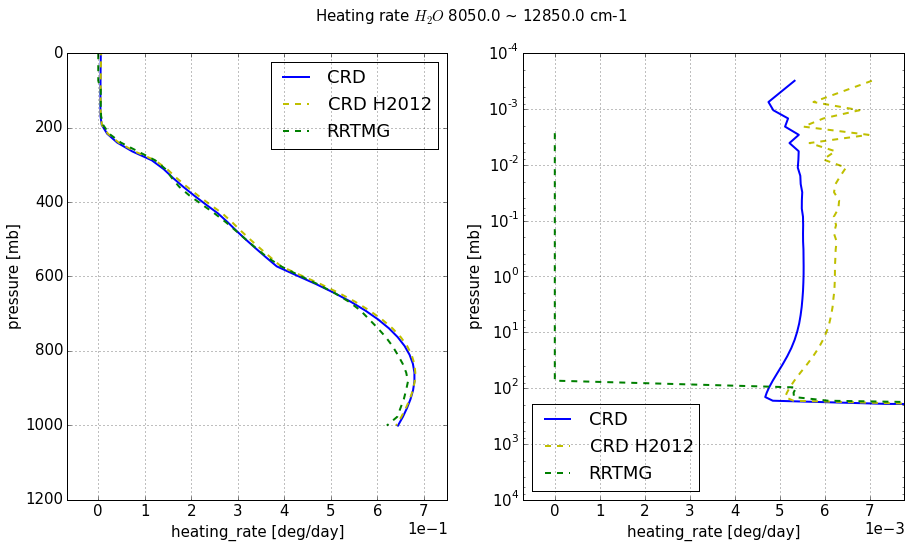

---------------------------------------------------------------------------


RRTMG Wavenumber band: 12850.0 ~ 16000.0 cm-1

CRD
       pressure  flux_up   flux_down    net_flux  heating_rate
70     0.002417        0  108.653750  108.653750      0.000045
30   299.800000        0  108.622362  108.622362      0.004964
0   1013.000000        0  103.098029  103.098029      0.136599

CRD H2012
       pressure  flux_up   flux_down    net_flux  heating_rate
70     0.002417        0  108.653756  108.653756      0.000091
30   299.800000        0  108.622684  108.622684      0.004914
0   1013.000000        0  103.191861  103.191861      0.134081

RRTMG
      pressure  flux_up  flux_difdown  flux_dirdown   flux_down    net_flux  \
70     0.00242       -0             0      109.0936  108.653750  108.653750   
30   299.70000       -0             0      109.0649  108.625166  108.625166   
0   1013.00000       -0             0      103.3554  102.938686  102.938686   

    heating_rate  
70       0.00

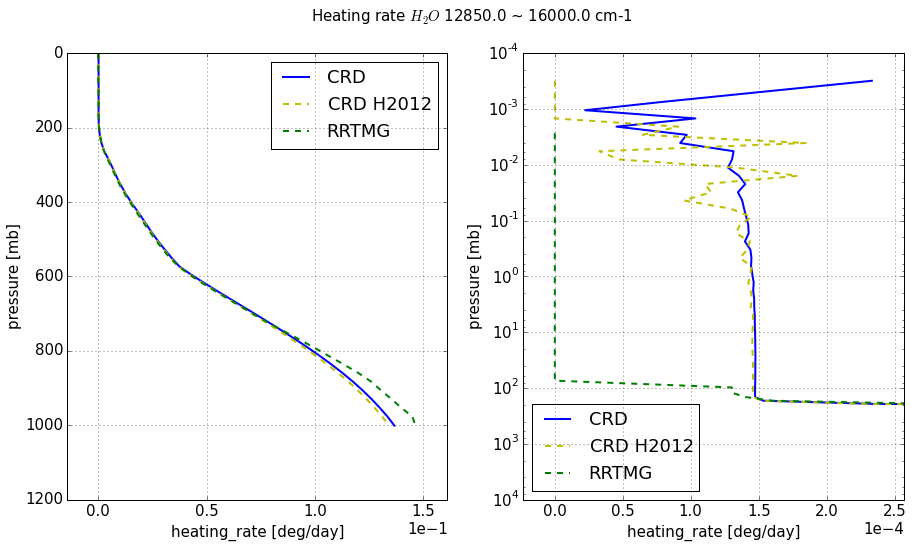

---------------------------------------------------------------------------


RRTMG Wavenumber band: 16000.0 ~ 22650.0 cm-1

CRD
       pressure  flux_up   flux_down    net_flux  heating_rate
70     0.002417        0  171.966627  171.966627      0.000000
30   299.800000        0  171.963216  171.963216      0.000544
0   1013.000000        0  170.861643  170.861643      0.034328

CRD H2012
       pressure  flux_up   flux_down    net_flux  heating_rate
70     0.002417        0  171.966629  171.966629      0.000000
30   299.800000        0  171.963107  171.963107      0.000563
0   1013.000000        0  170.816163  170.816163      0.035807

RRTMG
      pressure   flux_up  flux_difdown  flux_dirdown   flux_down    net_flux  \
70     0.00242 -0.000099             0      173.5962  171.966627  171.966528   
30   299.70000 -0.000099             0      173.5930  171.963457  171.963358   
0   1013.00000 -0.000000             0      172.4621  170.843173  170.843173   

    heating_rate  
70       

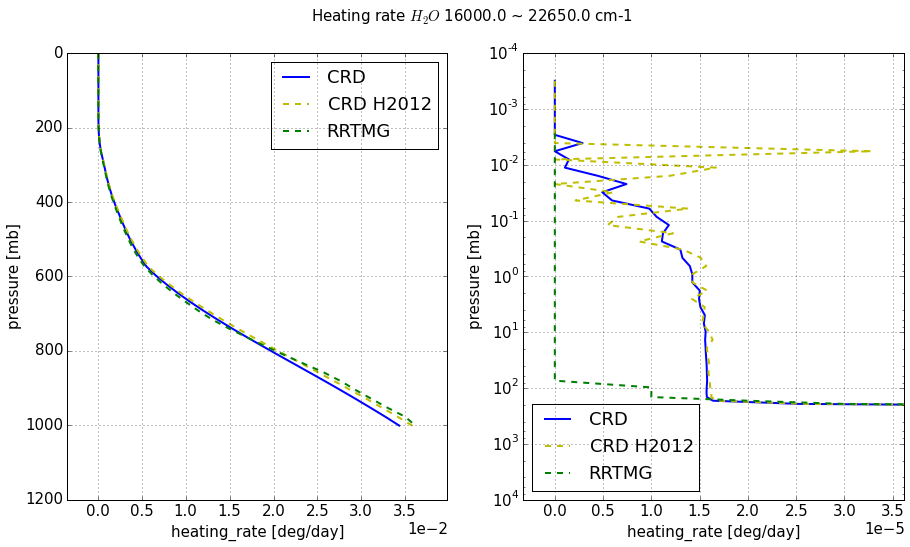

---------------------------------------------------------------------------


RRTMG Wavenumber band: 22650.0 ~ 29000.0 cm-1

CRD
       pressure  flux_up  flux_down   net_flux  heating_rate
70     0.002417        0  63.770666  63.770666      0.000000
30   299.800000        0  63.770657  63.770657      0.000001
0   1013.000000        0  63.767506  63.767506      0.000106

CRD H2012
       pressure  flux_up  flux_down   net_flux  heating_rate
70     0.002417        0  35.084367  35.084367      0.000000
30   299.800000        0  35.084354  35.084354      0.000002
0   1013.000000        0  35.079264  35.079264      0.000173

RRTMG
      pressure  flux_up  flux_difdown  flux_dirdown  flux_down   net_flux  \
70     0.00242       -0             0       64.7475  63.770666  63.770666   
30   299.70000       -0             0       64.7475  63.770666  63.770666   
0   1013.00000       -0             0       64.7475  63.770666  63.770666   

    heating_rate  
70             0  
30             0  

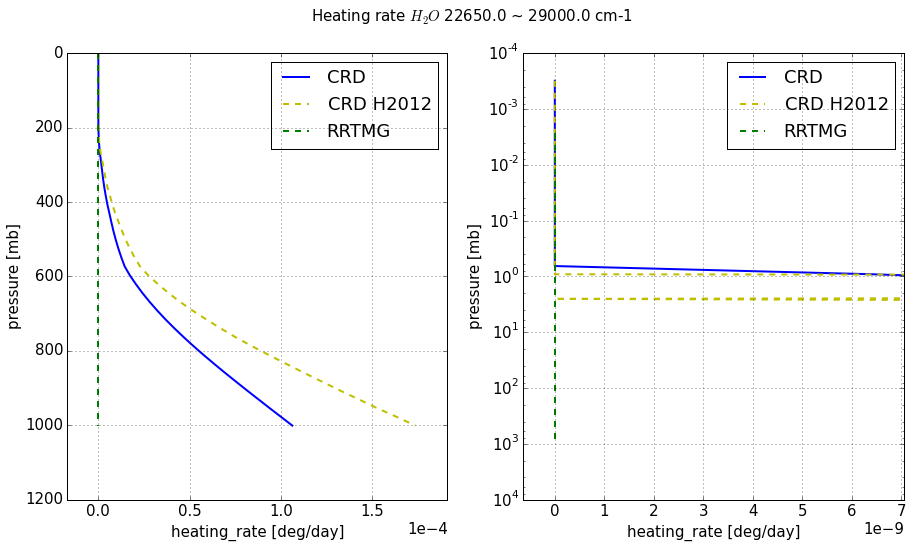

---------------------------------------------------------------------------


RRTMG Wavenumber band: 29000.0 ~ 38000.0 cm-1

CRD
       pressure  flux_up  flux_down   net_flux  heating_rate
70     0.002417        0  23.027941  23.027941             0
30   299.800000        0  23.027941  23.027941             0
0   1013.000000        0  23.027941  23.027941             0

CRD H2012
       pressure  flux_up  flux_down  net_flux  heating_rate
70     0.002417        0   0.026805  0.026805  0.000000e+00
30   299.800000        0   0.026805  0.026805  0.000000e+00
0   1013.000000        0   0.026801  0.026801  1.322751e-07

RRTMG
      pressure  flux_up  flux_difdown  flux_dirdown  flux_down   net_flux  \
70     0.00242       -0             0       25.0761  23.027941  23.027941   
30   299.70000       -0             0       25.0761  23.027941  23.027941   
0   1013.00000       -0             0       25.0761  23.027941  23.027941   

    heating_rate  
70             0  
30             0  
0  

/nuwa_cluster/home/jackyu/locally_installed_python_pacakges/anaconda3/lib/python3.4/site-packages/matplotlib/axes/_base.py:2544: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))


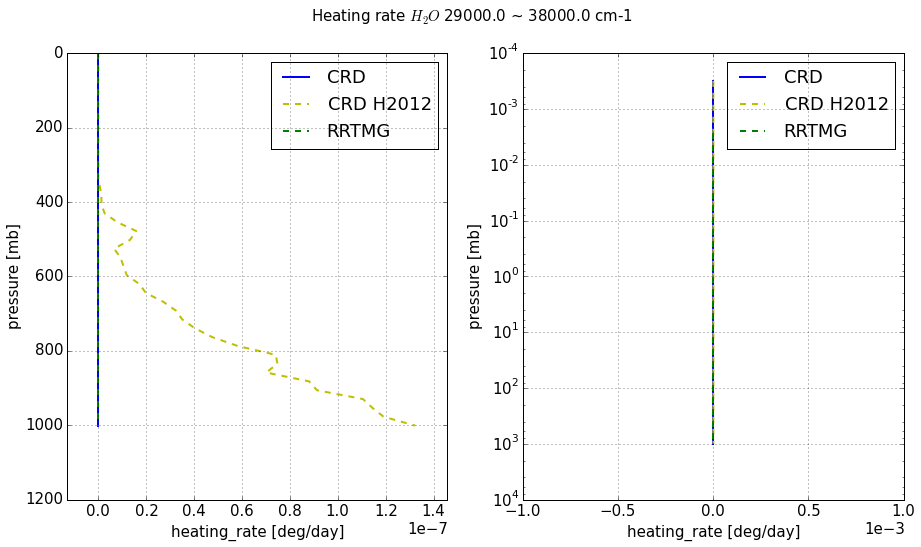

---------------------------------------------------------------------------


RRTMG Wavenumber band: 38000.0 ~ 50000.0 cm-1

CRD
       pressure  flux_up  flux_down  net_flux  heating_rate
70     0.002417        0   1.544534  1.544534             0
30   299.800000        0   1.544534  1.544534             0
0   1013.000000        0   1.544534  1.544534             0

CRD H2012
       pressure  flux_up  flux_down  net_flux  heating_rate
70     0.002417        0   0.026805  0.026805  0.000000e+00
30   299.800000        0   0.026805  0.026805  0.000000e+00
0   1013.000000        0   0.026801  0.026801  1.322751e-07

RRTMG
      pressure  flux_up  flux_difdown  flux_dirdown  flux_down  net_flux  \
70     0.00242       -0             0          1.54   1.544534  1.544534   
30   299.70000       -0             0          1.54   1.544534  1.544534   
0   1013.00000       -0             0          1.54   1.544534  1.544534   

    heating_rate  
70             0  
30             0  
0          

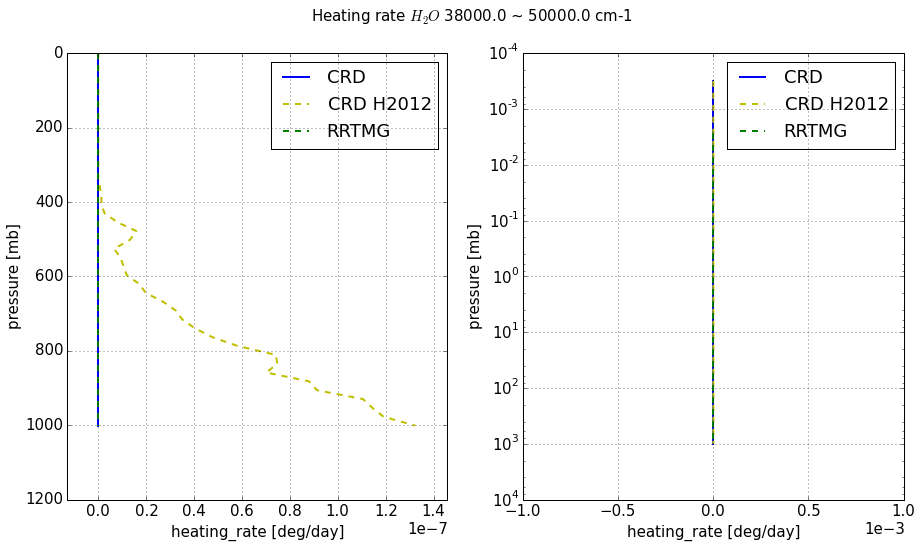

In [137]:
print('Flux tables and heating rates in RRTMG spectral bands')
print()
print()

fluxtableNhrplot_by_rrtmg_bands(pnl_rrtmg, \
                                ('CRD', 'b', '-', pnl_crd),
                               ('CRD H2012', 'y', '--', pnl_crd_H2012)) 

# In CLIRAD's wavenumber bands

In [122]:

def fluxtableNhrplot_by_clirad_bands(pnl_clirad, *infos_lbl):    
    global name_molecule, xlim_linear
    clirad_wbands = rtmtools.clirad.sw.info.wavenumber_bands()
    wbands = list(range(1, len(clirad_wbands) + 1))
    wranges = {wband: clirad_wbands[wband] for wband in wbands}
    
    atm_levels = [70, 30, 0]
    
    names, colours, linestyles, pnls_lbl = map(list, zip(*infos_lbl))
          
    pnls = [rtmtools.clirad.sw.analyse.lines2bands(pnl_lbl, wbands = wranges)\
            for pnl_lbl in pnls_lbl]
    
    names.append('CLIRAD')
    colours.append('b')
    linestyles.append('--')
    
    aeranalyse.normalise_by_TOA_flux_down(pnl_clirad, 
                                          normalise_to = pnls[0])
    pnls.append(pnl_clirad)
    
    for wband in wbands:
        print('---------------------------------------------------------------------------')
        print() 
        dfs = [pnl[wband].loc[atm_levels, :] for pnl in pnls]
        
        wlabel = ' '.join(['{} ~ {}'.format(*interval) for interval in wranges[wband]]) + ' cm-1'
        
        viz.tabulate_difference(dfs = dfs, 
                                names = names,
                                title = 'Wavenumber band: {}, {}'.format(wband, wlabel))
        
        dfs = [pnl[wband] for pnl in pnls]
        
        max_cr = max([df['heating_rate'].max() for df in dfs])
        
        viz.plot_pres_vs_hrcr(dfs = dfs,
                              names = names,
                              linestyles = linestyles, 
                              colours = colours,
                              title = 'Heating rate {} {}'.format(name_molecule, wlabel),
                              cooling_rate = False,\
                              xlim_linear = None,
                              xlim_log = None)
    
        display.display(plt.gcf()); plt.close()    


Flux tables and heating rates in CLIRAD spectral bands


---------------------------------------------------------------------------


Wavenumber band: 1, 35088 ~ 44444 cm-1

CRD
       pressure  flux_up  flux_down  net_flux  heating_rate
70     0.002417        0   3.514604  3.514604             0
30   299.800000        0   3.514604  3.514604             0
0   1013.000000        0   3.514604  3.514604             0

CRD H2012
       pressure  flux_up  flux_down  net_flux  heating_rate
70     0.002417        0   0.026805  0.026805  0.000000e+00
30   299.800000        0   0.026805  0.026805  0.000000e+00
0   1013.000000        0   0.026801  0.026801  1.322751e-07

CLIRAD
       pressure       flux_up  flux_down  net_flux  heating_rate
70     0.002417 -4.817478e-12   3.514535  3.514535      0.170928
30   299.800000 -2.064616e-12   2.147950  2.147950     -0.019623
0   1013.000000 -0.000000e+00   2.701357  2.701357     -0.001352

CRD - CRD H2012
    pressure  flux_up  flux_down  net_flux  h

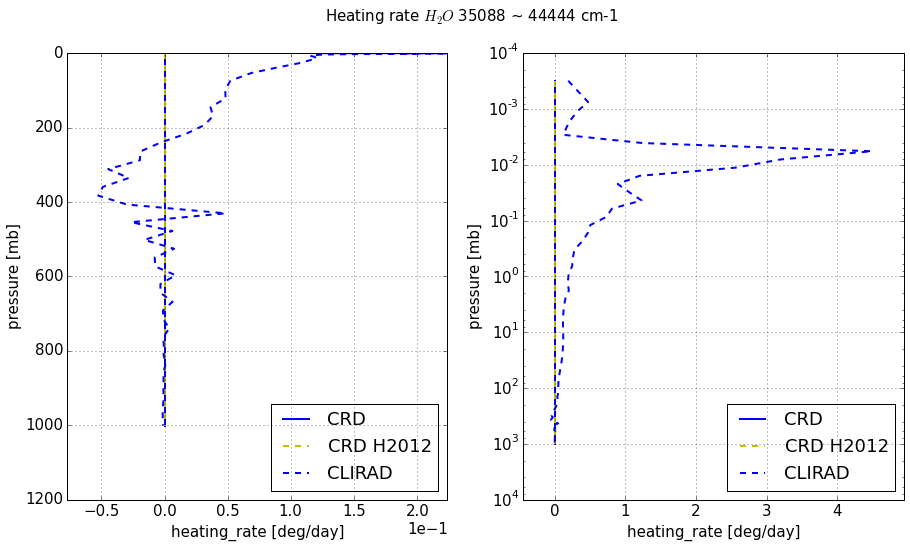

---------------------------------------------------------------------------


Wavenumber band: 2, 33333 ~ 35088 44444 ~ 57142 cm-1

CRD
       pressure  flux_up  flux_down  net_flux  heating_rate
70     0.002417        0   3.852331  3.852331             0
30   299.800000        0   3.852331  3.852331             0
0   1013.000000        0   3.852331  3.852331             0

CRD H2012
       pressure  flux_up  flux_down  net_flux  heating_rate
70     0.002417        0   0.053610  0.053610  0.000000e+00
30   299.800000        0   0.053610  0.053610  0.000000e+00
0   1013.000000        0   0.053603  0.053603  2.645502e-07

CLIRAD
       pressure       flux_up  flux_down  net_flux  heating_rate
70     0.002417 -7.469773e-13   3.852320  3.852320  2.327879e-02
30   299.800000 -3.201433e-13   3.852234  3.852234  6.795004e-07
0   1013.000000 -0.000000e+00   3.852171  3.852171  6.794891e-07

CRD - CRD H2012
    pressure  flux_up  flux_down  net_flux  heating_rate
70         0        0   3.79872

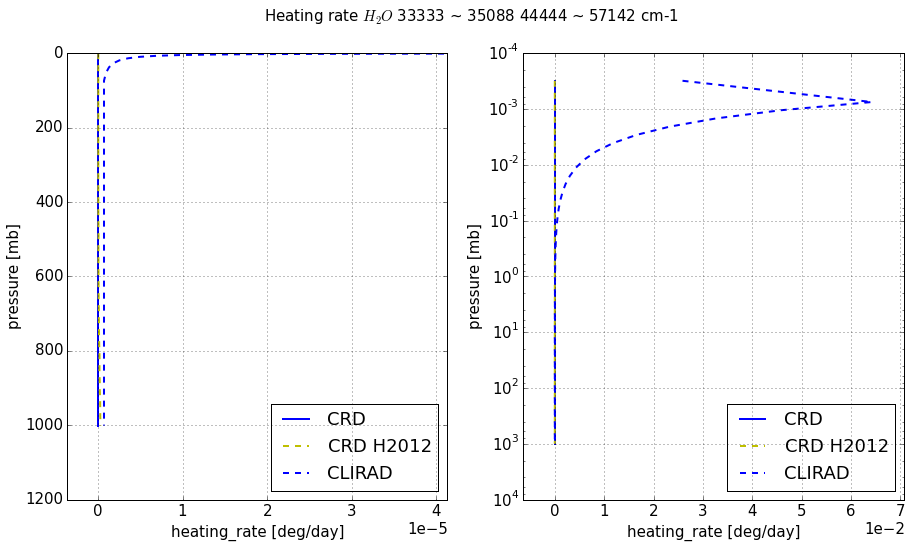

---------------------------------------------------------------------------


Wavenumber band: 3, 30770 ~ 33333 cm-1

CRD
       pressure  flux_up  flux_down  net_flux  heating_rate
70     0.002417        0   7.939345  7.939345             0
30   299.800000        0   7.939345  7.939345             0
0   1013.000000        0   7.939345  7.939345             0

CRD H2012
       pressure  flux_up  flux_down  net_flux  heating_rate
70     0.002417        0   0.026805  0.026805  0.000000e+00
30   299.800000        0   0.026805  0.026805  0.000000e+00
0   1013.000000        0   0.026801  0.026801  1.322751e-07

CLIRAD
       pressure       flux_up  flux_down  net_flux  heating_rate
70     0.002417 -1.662502e-13   7.939343  7.939343  5.518143e-03
30   299.800000 -7.127224e-14   7.939323  7.939323  1.610760e-07
0   1013.000000 -0.000000e+00   7.939309  7.939309  1.610757e-07

CRD - CRD H2012
    pressure  flux_up  flux_down  net_flux  heating_rate
70         0        0   7.912540  7.912540  0

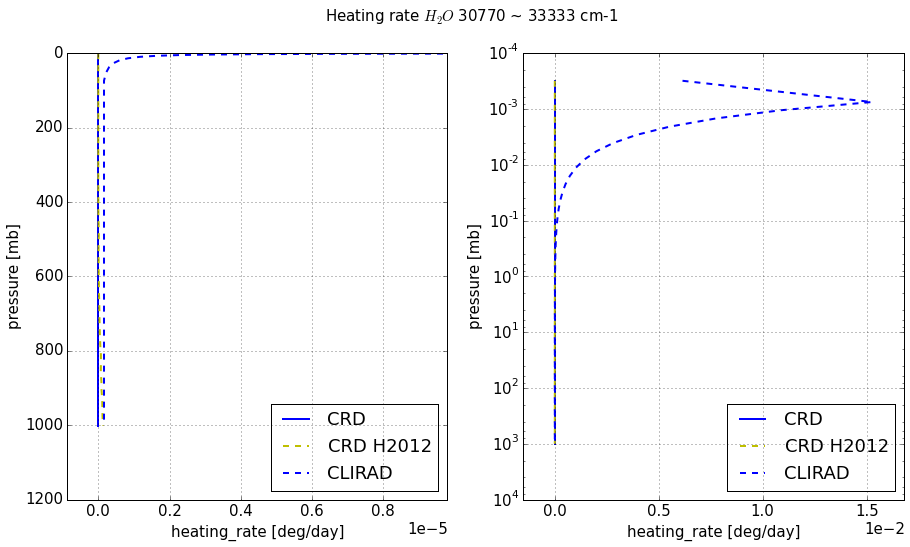

---------------------------------------------------------------------------


Wavenumber band: 4, 25000 ~ 30770 cm-1

CRD
       pressure  flux_up  flux_down   net_flux  heating_rate
70     0.002417        0  37.994457  37.994457  0.000000e+00
30   299.800000        0  37.994453  37.994453  6.398401e-07
0   1013.000000        0  37.993106  37.993106  4.493202e-05

CRD H2012
       pressure  flux_up  flux_down  net_flux  heating_rate
70     0.002417        0   0.026805  0.026805  0.000000e+00
30   299.800000        0   0.026805  0.026805  0.000000e+00
0   1013.000000        0   0.026801  0.026801  1.322751e-07

CLIRAD
       pressure       flux_up  flux_down   net_flux  heating_rate
70     0.002417 -2.755214e-13  37.994457  37.994457  1.006937e-02
30   299.800000 -1.181866e-13  37.994428  37.994428  2.939280e-07
0   1013.000000 -0.000000e+00  37.994400  37.994400  2.939279e-07

CRD - CRD H2012
    pressure  flux_up  flux_down   net_flux  heating_rate
70         0        0  37.967652  37

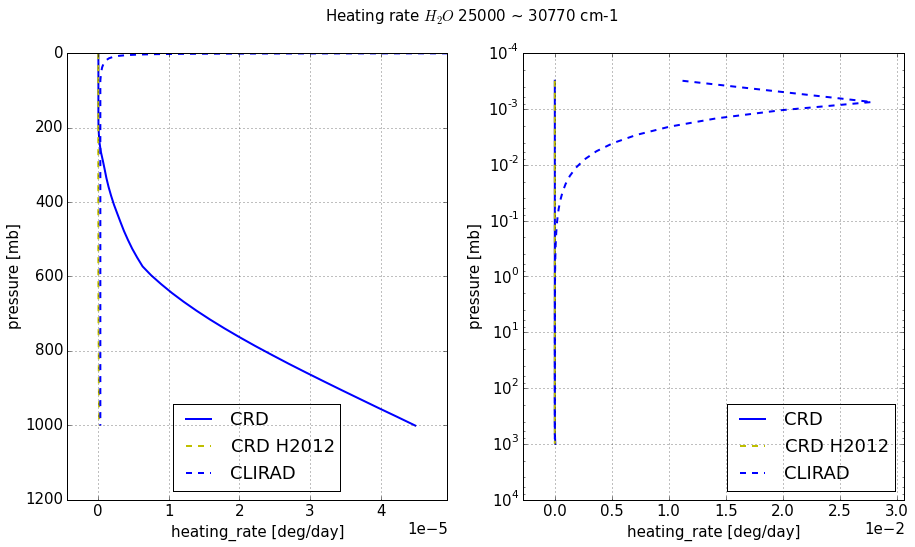

---------------------------------------------------------------------------


Wavenumber band: 5, 14286 ~ 25000 cm-1

CRD
       pressure  flux_up   flux_down    net_flux  heating_rate
70     0.002417        0  265.032084  265.032084      0.000006
30   299.800000        0  265.023952  265.023952      0.001294
0   1013.000000        0  262.667086  262.667086      0.070189

CRD H2012
       pressure  flux_up   flux_down    net_flux  heating_rate
70     0.002417        0  265.032088  265.032088      0.000000
30   299.800000        0  265.023806  265.023806      0.001320
0   1013.000000        0  262.601527  262.601527      0.072326

CLIRAD
       pressure       flux_up   flux_down    net_flux  heating_rate
70     0.002417 -1.313133e-08  265.032084  265.032084      0.068761
30   299.800000 -1.311769e-08  265.029308  265.029308      0.000462
0   1013.000000 -0.000000e+00  262.394720  262.394720      0.105804

CRD - CRD H2012
    pressure  flux_up  flux_down  net_flux  heating_rate
70       

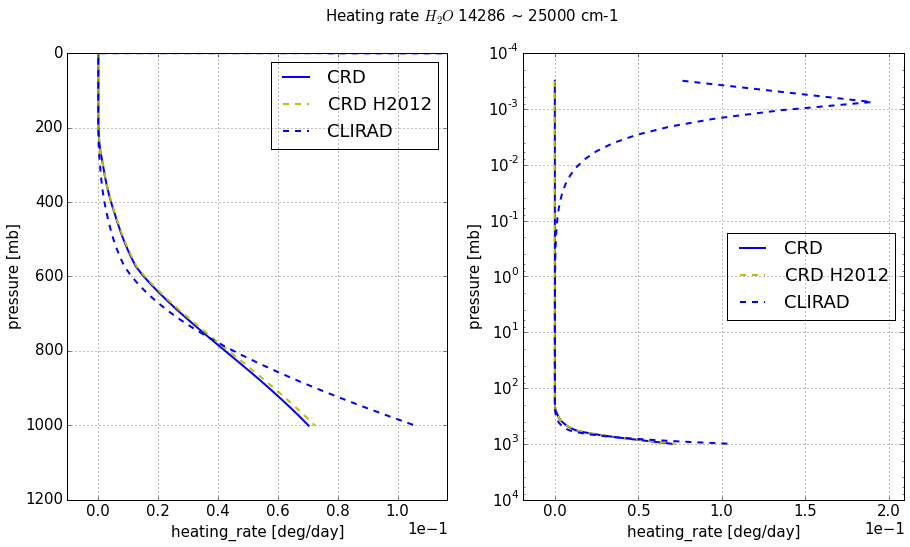

---------------------------------------------------------------------------


Wavenumber band: 6, 8200 ~ 14280 cm-1

CRD
       pressure  flux_up   flux_down    net_flux  heating_rate
70     0.002417        0  220.865503  220.865503      0.005160
30   299.800000        0  220.015104  220.015104      0.119130
0   1013.000000        0  176.023173  176.023173      0.735974

CRD H2012
       pressure  flux_up   flux_down    net_flux  heating_rate
70     0.002417        0  220.865516  220.865516      0.005619
30   299.800000        0  219.955098  219.955098      0.125926
0   1013.000000        0  175.592757  175.592757      0.728109

CLIRAD
       pressure   flux_up   flux_down    net_flux  heating_rate
70     0.002417 -0.000147  220.865303  220.865156      0.482215
30   299.800000 -0.000059  220.058050  220.057991      0.124549
0   1013.000000 -0.000000  175.214572  175.214572      0.705824

CRD - CRD H2012
    pressure  flux_up  flux_down  net_flux  heating_rate
70         0        0  -0.

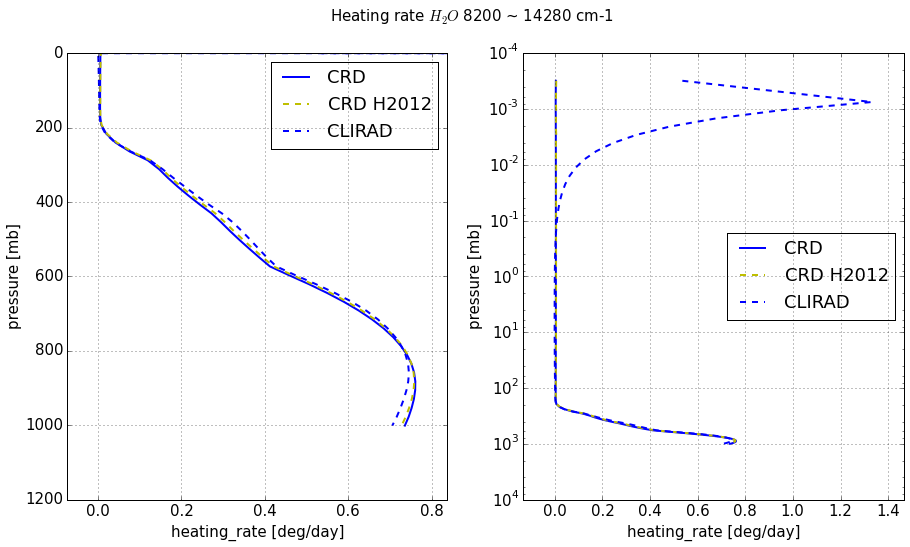

---------------------------------------------------------------------------


Wavenumber band: 7, 4400 ~ 8200 cm-1

CRD
       pressure  flux_up   flux_down    net_flux  heating_rate
70     0.002417        0  113.874482  113.874482      0.104813
30   299.800000        0  109.312006  109.312006      0.514142
0   1013.000000        0   65.972910   65.972910      0.315031

CRD H2012
       pressure  flux_up   flux_down    net_flux  heating_rate
70     0.002417        0  113.874481  113.874481      0.103635
30   299.800000        0  109.308523  109.308523      0.514424
0   1013.000000        0   65.936687   65.936687      0.317339

CLIRAD
       pressure   flux_up   flux_down    net_flux  heating_rate
70     0.002417 -0.000070  113.874411  113.874341      0.275648
30   299.800000 -0.000025  109.372959  109.372934      0.526873
0   1013.000000 -0.000000   68.443046   68.443046      0.293032

CRD - CRD H2012
    pressure  flux_up     flux_down      net_flux  heating_rate
70         0        

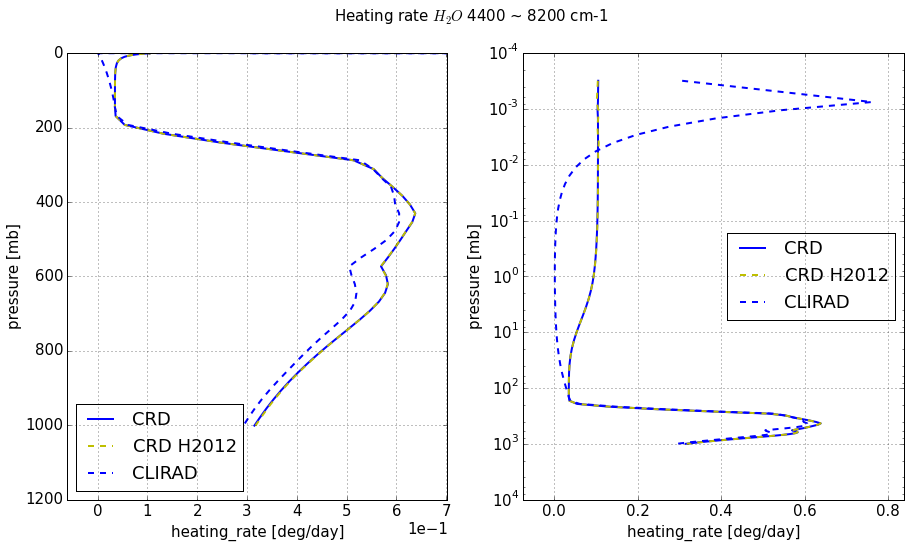

---------------------------------------------------------------------------


Wavenumber band: 8, 1000 ~ 4400 cm-1

CRD
       pressure  flux_up  flux_down   net_flux  heating_rate
70     0.002417        0  29.352153  29.352153      0.351053
30   299.800000        0  25.503405  25.503405      0.355012
0   1013.000000        0  10.547747  10.547747      0.100244

CRD H2012
       pressure  flux_up  flux_down   net_flux  heating_rate
70     0.002417        0  29.352152  29.352152      0.352367
30   299.800000        0  25.499421  25.499421      0.355324
0   1013.000000        0  10.532794  10.532794      0.100384

CLIRAD
       pressure   flux_up  flux_down   net_flux  heating_rate
70     0.002417 -0.000016  29.352215  29.352198      0.099339
30   299.800000 -0.000005  25.551349  25.551344      0.358429
0   1013.000000 -0.000000  11.293427  11.293427      0.097072

CRD - CRD H2012
    pressure  flux_up  flux_down  net_flux  heating_rate
70         0        0   0.000002  0.000002     -0.0

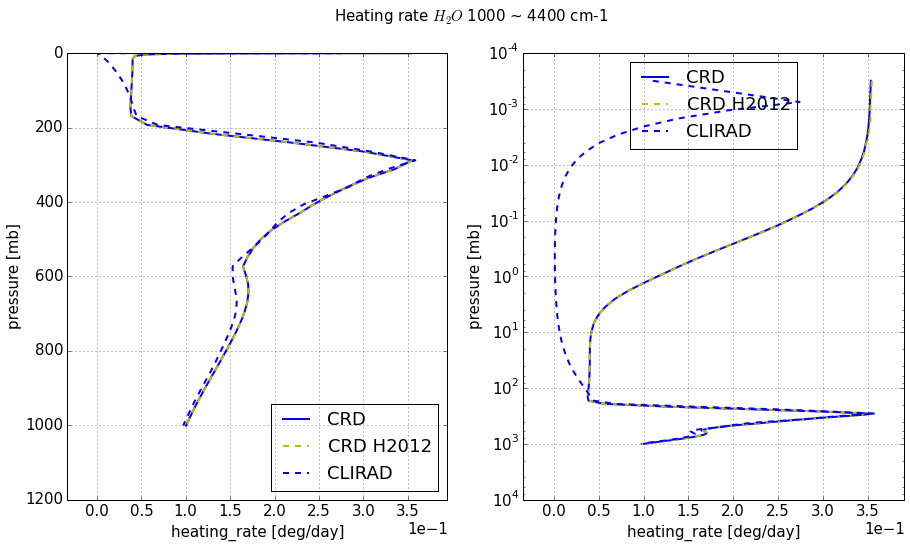

In [138]:
print('Flux tables and heating rates in CLIRAD spectral bands')
print()
print()

fluxtableNhrplot_by_clirad_bands(pnl_clirad, \
                                ('CRD', 'b', '-', pnl_crd),
                                ('CRD H2012', 'y', '--', pnl_crd_H2012))

In [44]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')